# Tutorial de Word2Vec 

## En pocas palabras...

El supuesto subyacente de Word2Vec es que dos palabras que comparten contextos similares también comparten un significado similar y, por consiguiente, una representación vectorial similar del modelo. Por ejemplo: "perro", "perrito" y "cachorro" se utilizan a menudo en situaciones similares, con palabras cercanas similares como "bueno", "peludo" o "lindo", y según Word2Vec compartirán por lo tanto una representación vectorial similar.

A partir de esta hipótesis, Word2Vec puede utilizarse para averiguar las relaciones entre las palabras de un conjunto de datos, calcular la similitud entre ellas, o utilizar la representación vectorial de esas palabras como entrada para otras aplicaciones, como la clasificación o agrupación de textos.

## Ejercicio

En este Notebook vamos a desarrollar un Word2Vec utilizando la librería [Gensim](https://radimrehurek.com/gensim/models/word2vec.html) La cual es una de las más importantes en NLP.  Además de este módulo, para constuir un modelo robusto necesitamos: 
- Un corpus con suficiente contenido para crear un modelo 'inteligente'
- Limpiar y preporcesar el corpus.
- Suficiente RAM para entrenar el modelo (Es computancionalmente exigente) 

En este caso, vamos a crear un modelo específico para el show **Los Simpson's** 

Además de Gensim, también vamos a tener que instalar: 
- xlrd==1.1.0: https://pypi.org/project/xlrd/
- spaCy==2.0.12: https://spacy.io/usage/
- gensim==3.4.0: https://radimrehurek.com/gensim/install.html
- scikit-learn==0.19.1: http://scikit-learn.org/stable/install.html
- seaborn==0.8: https://seaborn.pydata.org/installing.html


In [6]:
import re  # Procesamiento de Texto
import pandas as pd  
from time import time  # Medir tiempo de ejecucion
import multiprocessing
import logging  # Sacar logs del modelo

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from collections import defaultdict  
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
import gensim.downloader as api

import spacy  # Procesamiento NLP


# Config Logs
logging.basicConfig(
    format="%(levelname)s - %(asctime)s: %(message)s", 
    datefmt= '%H:%M:%S', 
    level=logging.INFO
    )
# Configuramos estilo de arte de los plots.
sns.set_style("darkgrid")


In [7]:
# DATA DIR 
url = 'https://raw.githubusercontent.com/pfernandez-sanofi/ml_tutorials/main/DATA/simpson_dataset.csv'
# cargamos datos 
df = pd.read_csv(url)
df.head()

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...


In [8]:
# datos nulos 
# Hay bastantes nulos que no nos van a servir para este proyecto
# los podemos eliminar directamente 
df.isnull().sum() # cantidad de nulos por columna

raw_character_text    17814
spoken_words          26459
dtype: int64

In [9]:
df = df.dropna().reset_index(drop=True) # eliminamos nulos 

# Limpieza del texto

Descargarse model de spacy english (o cualquier idioma): 
```python -m spacy download en_core_web_sm```

In [13]:
# !python -m spacy download en_core_web_sm

In [14]:
nlp = spacy.load(
  'en_core_web_sm',  # Capaz sea necesario descargar modelo de Spacy English.
  disable=['ner', 'parser']  # desactivamos modelos por facilidad de procesamiento
  ) 

def cleaning(doc):
  """
  Lemmatiza y elimina stopwords
  Necesitamos un doc como lo describe spacy
  :param doc: DOC según lo describe Spacy. 
  :return: Una cadena de texto. 
  """
  txt = [token.lemma_ for token in doc if not token.is_stop]
  # Word2Vec usa el contexto para entender la reperesentacion de la palabra
  # Si la oracion es corta, no va a aprender mucho
  if len(txt) > 2:
      return ' '.join(txt)
# Reemplazamos todo lo que no sea alphanum por espacio
brief_cleaning = (
  re.sub(r"[^A-Za-z0-9']+", 
  ' ', 
  str(row)).lower().strip() for row in df['spoken_words']  # por cada fila en df.
  )

In [16]:
# Usamos el método Pipe de Spacy para procesar con mayor velocidad
t = time() # Calculamos tiempo

txt = [
    cleaning(doc) for doc in nlp.pipe(
        brief_cleaning, # función que def antes
        batch_size=5000, 
        n_process=-1 # usamos todos los cores
    )
]
# medimos tiempo de ejecución 
t_ = round((time() - t) / 60, 2) # Tiempo de ejecucion en mins
print(f'Tiempo de ejecución: {t_} mins')

Tiempo de ejecución: 0.9 mins


In [17]:
# Eliminamos duplicados o nulos si se han generado.
clean_txt = set(txt) # eliminamos duplicados 
clean_txt = [tx for tx in clean_txt if tx] # eliminamos nuevos nulos que se han creado

In [18]:
clean_txt[:4] # mostramos 'cabecera'

['yeah talk look encase telephone concrete',
 'know come go',
 'forget love jebediah springfield',
 'dangerous life hall monitor leave home morning kiss doll goodbye time']

## Phraser (N gramas)

En NLP, nos interesa mantener el contexto alrededor de una palabra. Por ello, es útil también unificar palabras como un token único. Por ejemplo, nos intersa que el término "Big Data" sea considerado como un token único, así, cuando aparezcan juntas, sean consideradas bajo el mismo contexto. Es decir, pasaríamos de tener dos tokens: "Big" y "Data" a un único token: "big_data". 

In [19]:
# Phraser une palabras que usualmente están juntas,
# Por ejemplo Big Data -> big_data
sentences  = [row.split() for row in clean_txt if row]
phrases = Phrases(sentences, min_count=10, progress_per=10000)
bigram = Phraser(phrases)
ngram_sentences = bigram[sentences] 
# Vemos el vocabulario que hemos creado 
# Sanity check 
word_freq = defaultdict(int)
for sent in ngram_sentences:
    for i in sent:
        word_freq[i] += 1
print(f'El corpus tiene {len(word_freq)} palabras') 



INFO - 16:48:20: collecting all words and their counts
INFO - 16:48:20: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 16:48:20: PROGRESS: at sentence #10000, processed 62907 words and 55200 word types
INFO - 16:48:20: PROGRESS: at sentence #20000, processed 125546 words and 99569 word types
INFO - 16:48:20: PROGRESS: at sentence #30000, processed 187685 words and 139609 word types
INFO - 16:48:20: PROGRESS: at sentence #40000, processed 250247 words and 177234 word types
INFO - 16:48:20: PROGRESS: at sentence #50000, processed 313037 words and 212955 word types
INFO - 16:48:20: PROGRESS: at sentence #60000, processed 375766 words and 247194 word types
INFO - 16:48:20: PROGRESS: at sentence #70000, processed 438671 words and 280534 word types
INFO - 16:48:20: PROGRESS: at sentence #80000, processed 501326 words and 312559 word types
INFO - 16:48:20: collected 331228 token types (unigram + bigrams) from a corpus of 538158 words and 85870 sentences
INFO - 16:48:20: m

El corpus tiene 30442 palabras


In [20]:
# Miramos las palabras más comunes 
sorted(word_freq, key=word_freq.get, reverse=True)[:10]


['oh', 'like', 'know', 'get', 'hey', 'think', 'come', 'right', 'look', 'want']

In [22]:
sorted(
    {w: v for w,v in word_freq.items() if "_" in w},
    key=word_freq.get,
    reverse=True
)[:10]

['go_to',
 'get_to',
 'homer_simpson',
 'oh_god',
 'wait_minute',
 'mr_burn',
 'mr_simpson',
 'bart_simpson',
 'mr_burns',
 'woo_hoo']

## Entrenamos nuestro Word2Vec.

Una vez ejecutado el preprocesamiento, estamos listos para crear nuestro modelo de lenguaje. 

In [25]:

cores = multiprocessing.cpu_count() # Cuenta el num de cores disponibles
#  The model (see Gensim's Word2Vec for more info )
w2v_model = Word2Vec(
    min_count=10,  # Num Mínimo de apariciones
    window=2,
    sample=6e-5, 
    alpha=0.03, 
    min_alpha=0.0007, 
    negative=20,       
    workers=cores-1   # A toda maquina
    )
#  Construimos el vocablo para gensim
w2v_model.build_vocab(ngram_sentences, progress_per=10000)

#  Entrenamos el modelo (Toma unos minutos)

w2v_model.train(
    ngram_sentences, 
    total_examples=w2v_model.corpus_count, 
    epochs=30, # Mientras más epochs, más iteraciones de entrenamiento.
    report_delay=1   
    )

INFO - 16:51:58: Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=100, alpha=0.03>', 'datetime': '2022-08-21T16:51:58.786939', 'gensim': '4.2.0', 'python': '3.9.7 (default, Sep 16 2021, 08:50:36) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
INFO - 16:51:58: collecting all words and their counts
INFO - 16:51:58: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 16:51:58: PROGRESS: at sentence #10000, processed 60431 words, keeping 10667 word types
INFO - 16:51:58: PROGRESS: at sentence #20000, processed 120636 words, keeping 15427 word types
INFO - 16:51:58: PROGRESS: at sentence #30000, processed 180311 words, keeping 18860 word types
INFO - 16:51:59: PROGRESS: at sentence #40000, processed 240488 words, keeping 21620 word types
INFO - 16:51:59: PROGRESS: at sentence #50000, processed 300715 words, keeping 23982 word types
INFO - 16:51:59: PROGRESS: at sentence #60000, processed 361003 words, keeping 25955

(6994312, 15515730)

## Ahora con el modelo entrenado, podemos probar los resultados. 
Una de las claves del W2V es poder medir la similitud entre términos. Esto se hace mediante la famosa word mover distance, que es una variación de la distancia coseno entre los vectores de las palabras. 

Recuerda que en este caso, utilizamos los diálogos de los personajes, por lo que si buscamos lo más similar a "Homer", no vamos a obtener muchas de las tradicionales frases del personaje, ya que muy rara vez Homer se refirirá a sí mismo en tercera persona. Más bien, se obtiene las palabras que usualmente acompañan al nombre 'Homer'. 

In [26]:
# Palabra más similar a homero
w2v_model.wv.most_similar(positive=["homer_simpson"])

[('congratulate', 0.7163152694702148),
 ('incompetent', 0.70997154712677),
 ('montgomery_burn', 0.696269690990448),
 ('recent', 0.693755567073822),
 ('isabel', 0.6890066862106323),
 ('montgomery', 0.6870659589767456),
 ('burns', 0.6870018839836121),
 ('signature', 0.6840088963508606),
 ('waylon', 0.6769089102745056),
 ('congratulation', 0.6756958961486816)]

In [27]:
w2v_model.wv.most_similar(negative=["homer_simpson"])

[('slow', 0.08024802803993225),
 ('wet', 0.07124341279268265),
 ('wrap', 0.0504545196890831),
 ('sock', 0.04605364054441452),
 ('crawl', 0.044993117451667786),
 ('pant', 0.04221682623028755),
 ('hurry', 0.04120471328496933),
 ('whoa', 0.03750438988208771),
 ('window', 0.03624683618545532),
 ('bed', 0.030478423461318016)]

In [28]:
w2v_model.wv.most_similar(positive=["marge"])


[('terribly', 0.7653266191482544),
 ('homey', 0.7474462985992432),
 ('hurt_feeling', 0.736965537071228),
 ('jessica', 0.73585444688797),
 ('homie', 0.7306194305419922),
 ('stay_mad', 0.7304099798202515),
 ('owl', 0.7292783856391907),
 ('midge', 0.7271341681480408),
 ('sarah', 0.726590633392334),
 ('sham', 0.7260987758636475)]

In [29]:
w2v_model.wv.most_similar(positive=["bart"])


[('lisa', 0.8448894023895264),
 ('mom', 0.7875449061393738),
 ('darle', 0.7779736518859863),
 ('handful', 0.7765873074531555),
 ('embarrassed', 0.7745743989944458),
 ('learn_lesson', 0.7711077332496643),
 ('dentist', 0.7656369209289551),
 ('take_care', 0.7573257088661194),
 ('vicki', 0.7573007345199585),
 ('dr_hibbert', 0.754142165184021)]

También podemos calcular la similitud entre dos términos. Por ejemplo, Moe y Tavern

In [41]:
w2v_model.wv.similarity("tavern", 'moe')


0.6003559

In [31]:
w2v_model.wv.similarity("barney", 'drunk')


0.7141513

In [32]:
w2v_model.wv.similarity('maggie', 'baby')


0.71392524

In [37]:
w2v_model.wv.similarity('marge', 'drunk')


0.47083542

Gensim también nos permite extraer el 'Outlier', o el valor atípico

In [42]:
w2v_model.wv.doesnt_match(['jimbo', 'milhouse', 'kearney'])


'milhouse'

In [43]:
w2v_model.wv.doesnt_match(["nelson", "bart", "milhouse"])


'nelson'

### Diferencia Análoga:

Esto se podria entender como 'ecuaciones' con los embeddings. Es decir, por ejemplo, tomamos el vector de Woman, le sumamos el de Bart y le restamos el de Man. 

También se interpreta como, qué palabra es para Woman lo que Bart es para Man. 
Veamos qué resulta...



In [45]:
w2v_model.wv.most_similar(positive=["woman", "bart"], negative=["man"], topn=1)

[('lisa', 0.701404333114624)]

In [47]:
w2v_model.wv.most_similar(positive=["wife",'marge'], negative=["homer"], topn=1)

[('husband', 0.6428989171981812)]

In [48]:
w2v_model.wv.most_similar(positive=["husband",'marge'], negative=["man"], topn=1)

[('homie', 0.6431085467338562)]

## Visualizaciones 

In [58]:
 w2v_model.wv.__getitem__(["homer_simpson"])

array([[-0.10676265,  0.44352537,  0.47803506,  0.33899945,  0.40913835,
        -0.1426215 ,  0.02780621,  0.65617865, -0.30069846,  0.01856746,
        -0.11890085, -0.18334484, -0.43404195,  0.62058717, -0.32419193,
        -0.5755058 ,  0.22103874, -0.33732215,  0.07132553,  0.09592833,
         0.4053109 ,  0.35967   ,  0.07455739,  0.22278275,  0.45013016,
        -0.01169584, -0.23770514,  0.34457558, -0.5490678 , -0.2943379 ,
        -0.09200644,  0.19360243,  0.21125796,  0.03925429,  0.10282575,
        -0.24532916, -0.3480221 , -0.24998005, -0.32696706,  0.048963  ,
         0.23666091, -0.47865313, -0.16026968,  0.23586547,  0.5037241 ,
        -0.03374351, -0.5444503 ,  0.5782578 ,  0.17366527,  0.01906559,
        -0.04903534,  0.20865765, -0.741104  , -0.27807498, -0.21002834,
         0.2102196 ,  0.14918508,  0.22967108, -0.14529476, -0.3410513 ,
        -0.01542542, -0.05238789, -0.33851007,  0.6284243 , -0.36228588,
         0.9045825 ,  0.22537409,  0.24239168,  0.2

In [55]:
#  Plotting
def tsnescatterplot(model: Word2Vec, word: str, list_names: list):
    """ 
    Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    :param model: A gensim word2vec model. 
    :param word: Keyword to compare to the list_names
    :param list_names: A user defined set list of words to compare to the main word.
    :return: A plot
    """
    arrays = np.empty((0, 100), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 20 dimensions with PCA
    reduc = PCA(n_components=20).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={
                         's': 40,
                         'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(
            df["x"][line],
            df['y'][line],
            '  ' + df["words"][line].title(),
            horizontalalignment='left',
            verticalalignment='bottom', size='medium',
            color=df['color'][line],
            weight='normal'
            ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title(f't-SNE visualization for {word.title()}')
    plt.show();

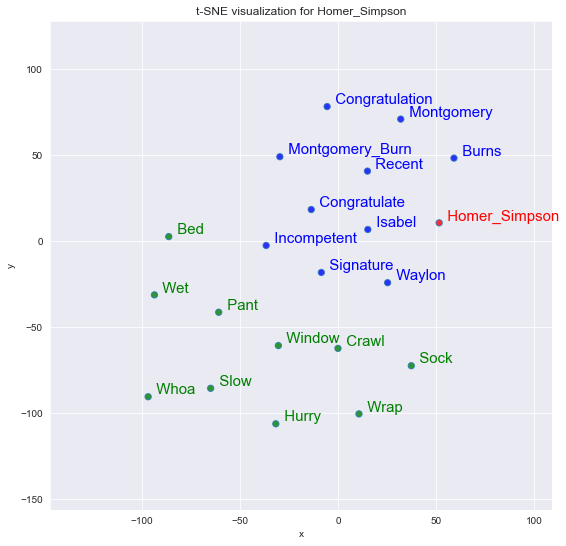

In [57]:
main_word = "homer_simpson"  # Palabra buscada
alternative_list =  [
    i[0] for i in w2v_model.wv.most_similar(
        negative=[main_word]  # Palabras negativas (opuestas)
        )
    ] 
# Llamamos a nuestra función
tsnescatterplot(w2v_model, main_word, alternative_list)

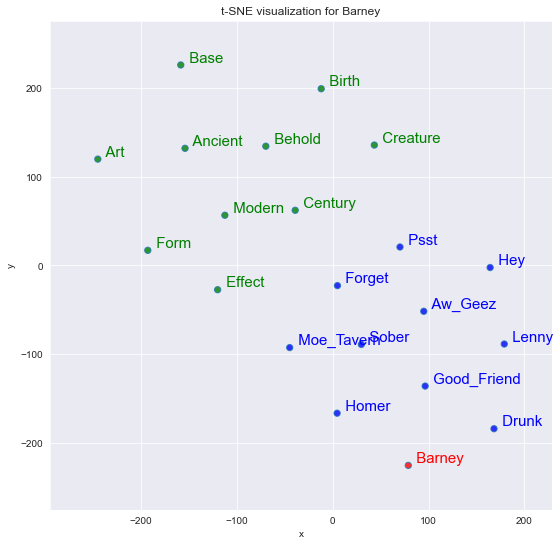

In [61]:
main_word = "barney"
alternative_list =  [
    i[0] for i in w2v_model.wv.most_similar(
        negative=[main_word]  # Palabras negativas (opuestas)
        )
    ] 
tsnescatterplot(w2v_model, main_word, alternative_list)

# Cargar un modelo pre-entrenado.

No siempre será necesario entrenar un modelo propio y específico para el caso de uso. En internet y dentro de la misma librería Gensim se pueden encontrar varios modelos entrenados previamente con diferentes corpus y que tendrán mejor o peor desempeño dependiendo de la industria y caso de uso. Por ejemplo, se pueden encontrar modelos generalistas entrenados con artículos de Wikipedia, u otros más especializados con artículos médicos como los de [SciSpacy](https://allenai.github.io/scispacy/)

Esto nos permitirá aprovechar de las múltiples funcionalidades de un Embedding sin tener que pasar por la costosa fase de entrenamiento.

En Gensim podemos utilizar algunos de los modelos y corpus ya preparados de esta [lista](https://radimrehurek.com/gensim/auto_examples/howtos/run_downloader_api.html)


Para este caso cargaremos el famoso [Glove Wiki Gigaword (50)](https://nlp.stanford.edu/projects/glove/) que es otra aproximación de word embeddings. El Word2Vec toma los textos como datos de entrenamiento para una red neuronal. Los vectores resultantes captan si las palabras aparecen en contextos similares. GloVe se centra en las co-ocurrencias de palabras en todo el corpus. Sus vectores se relacionan con las probabilidades de que dos palabras aparezcan juntas. Sin embargo, a pesar de que su entrenamiento y marco teorico sean distitnos, en Gensim su uso es prácticamente igual. 

In [ ]:
# Cargamos el modelo en memoria
model = api.load('glove-wiki-gigaword-50')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
# Lo probamos :) 
model.wv.most_similar(positive=["tree"])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('trees', 0.887702465057373),
 ('pine', 0.78980553150177),
 ('flower', 0.7542153000831604),
 ('oak', 0.7453586459159851),
 ('green', 0.7451863288879395),
 ('leaf', 0.7414467334747314),
 ('bark', 0.719155490398407),
 ('planted', 0.7050560712814331),
 ('cedar', 0.7033277153968811),
 ('garden', 0.7028761506080627)]

In [ ]:
model.wv.most_similar(positive=["queen"])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('princess', 0.851516604423523),
 ('lady', 0.805060863494873),
 ('elizabeth', 0.787304162979126),
 ('king', 0.7839042544364929),
 ('prince', 0.7821860909461975),
 ('coronation', 0.7692778706550598),
 ('consort', 0.7626097202301025),
 ('royal', 0.7442864775657654),
 ('crown', 0.7382649779319763),
 ('victoria', 0.7285771369934082)]

Podemos ver que relaciona términos parecidos correctamente, pero,  ¿realmente entiende el contexto? Hagamos una prueba. En teoría, si yo tomo el vector de la palabra rey, le sumo el vector de la palabra mujer y le resto el vector de la palabra hombre, debería tener su contra-parte mujer, es decir, Reina. 
Lo probamos!

In [ ]:
model.wv.most_similar(positive=["king",'woman'], negative=["man"], topn=3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('queen', 0.8523603677749634),
 ('throne', 0.7664334177970886),
 ('prince', 0.759214460849762)]

# Comparando frases con Word-Embeddings

Ya hemos comprobado que estos modelos son capaces de entender palabras sueltas y relacionarlas entre ellas, sin embargo, lo que realmente nos interesa es que estos algoritmos logren entender frases, artículos y guiones para que puedan tener aplicaciones 'de la vida real'. 
**Para ello, vamos a crear un mini-buscador inteligente.**

In [ ]:
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords 
import re
import numpy as np
import pandas as pd
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('wordnet')
nltk.download("stopwords")
stopwords_en = stopwords.words("english")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def doc2vec(word2vec: Word2Vec, tokenized_sentence: list) -> np.array:
  """
  Obtiene vectores de un conjunto de palabras (oracion) 
  :param word2vec: Modelo de Word2Vec o similar entrenado por Gensim
  :param tokenized_sentence: iterable de tokens.
  :return: Un array con los vectores. 
  """
  try: 
    words = [word for word in tokenized_sentence if word in word2vec.vocab]
  except AttributeError:  # Gensim cambio la API.
    words = [word for word in tokenized_sentence if word in word2vec.wv.vocab]
  if len(words) > 0:
    return np.mean(word2vec[words], axis=0)
  else:
    return np.array([])

def tokenizer(text: str, stem_or_lemmatize: str = "stem", pos: str ="n"):
  """
  Tokeniza el texto utilizando el RegexpTokenizer. 
  También elimina stopwords y lematiza o 'stemmatiza' los tokens. 
  :param text: Cadena de texto 
  :param stem_or_lemmatize: parametro para realizar stemming o lemmatization, 
    opciones son {'stem','lemmatize','none'}
  :param pos: Pos según describe NLTK en la lematización, por defecto es 'n'
  :return: Lista de tokens. 
  """
  min_length = 3
  reg_tokenizer = nltk.RegexpTokenizer(r"\w+")
  words = map(lambda word: word.lower(), reg_tokenizer.tokenize(text))
  #####
  words = [word for word in words if word not in stopwords_en and len(word) >= min_length]
  if stem_or_lemmatize == "stem":
    tokens = (list(map(lambda token: PorterStemmer().stem(token), words)))
  elif stem_or_lemmatize == "lemmatize":
    tokens = (list(map(lambda token: WordNetLemmatizer().lemmatize(token, pos=pos), words)))
  elif stem_or_lemmatize == "none":
    tokens = words
  else:
    raise Exception("Unknown stem_or_lemmatize parameter: "+stem_or_lemmatize)
  p = re.compile("[a-zA-Z]+")
  tokens = list(filter(lambda token: p.match(token) and len(token) >= min_length, tokens))
  return tokens


def tokenize_sentences(
  sentences: list, 
  stem_or_lemmatize: str = "lemmatize", 
  pos: str = "n"
  ):
  """
  tokenize sentences
  """
  return [tokenizer(s, stem_or_lemmatize, pos) for s in sentences]

def similarity(vec_1, vec_2):
  """
  Aplica similitud coseno entre dos vectores. 
  :param vec_1,vec2: vector tipo array 
  :return: Float 
  """
  if len(vec_1) == 0 or len(vec_2) == 0:
    return 0.0
  return np.dot(vec_1, vec_2) / (np.linalg.norm(vec_1) * np.linalg.norm(vec_2))


In [ ]:
def realizar_consulta(top_n: int = 3): 
  query = input('Su búsqueda (inglés):')
  token_query = tokenizer(query) # Tokenizamos la query
  query_embedding = doc2vec(model, token_query) # sacamos los vectores
  sim_matrix = [similarity(query_embedding, vec_2) for vec_2 in embeddings_2] # similitud con corpus
  sentence_indeces = np.argsort(sim_matrix, axis=0)[::-1][:top_n] # ordenamos y elegimos los top_n
  # imprimimos resultados
  print(f'Query original: {query}')
  print('--------------------')
  print('Oraciones más similares encontradas...')
  for index in sentence_indeces: 
    print(f'Oracion: {sentences_2[index]} -- > con similitud :{sim_matrix[index]}')


In [ ]:
lista_canciones = [
                  "hold the line, love isn't always on time.", 
                  "it's my life, it's now or never, I'm not gonna live for ever",
                  "Nothing to prove and I'm bulletproof and Know what I'm doing The way we're movin' like introducing", 
                  "Beat it, beat it no one wants to be defeated", 
                  "Near, far, wherever you are, I believe that the heart does go on. Once more you open the door",
                  "I'm Slim Shady, yes I'm the real Shady. All you other Slim Shadys are just imitating", 
                  'I want to fly like and eagle' 
                  ]

# Preparamos los vectores del corpus de consulta
sentences_2 = lista_canciones # Lista donde vamos a buscar lo más similar
tok_sentences_2 = tokenize_sentences(sentences_2) # tokenizamos
embeddings_2 = [doc2vec(
    model, tok_sent) for tok_sent in tok_sentences_2] # Pasamos a vectores


Algunas queries que vamos a probar con nuestro mini-buscador: 

- I wish to glide like a feathered animal. 
- Eminem 
- No need to hurry for love, there is always time
- This is the moment, I live in the present
- I will love you always, no matter where you are

In [ ]:
realizar_consulta(top_n = 3)

Su búsqueda (inglés):I wish to glide like a feathered animal
Query original: I wish to glide like a feathered animal
--------------------
Oraciones más similares encontradas...
Oracion: I want to fly like and eagle -- > con similitud :0.7338992953300476
Oracion: Nothing to prove and I'm bulletproof and Know what I'm doing The way we're movin' like introducing -- > con similitud :0.6928609609603882
Oracion: hold the line, love isn't always on time. -- > con similitud :0.6345545053482056


In [ ]:
realizar_consulta(top_n = 3)

Su búsqueda (inglés):Eminem
Query original: Eminem
--------------------
Oraciones más similares encontradas...
Oracion: I'm Slim Shady, yes I'm the real Shady. All you other Slim Shadys are just imitating -- > con similitud :0.4656716585159302
Oracion: it's my life, it's now or never, I'm not gonna live for ever -- > con similitud :0.36964696645736694
Oracion: Nothing to prove and I'm bulletproof and Know what I'm doing The way we're movin' like introducing -- > con similitud :0.27201056480407715


In [ ]:
realizar_consulta(top_n=3)

Su búsqueda (inglés):no need to hurry for love, there is always time
Query original: no need to hurry for love, there is always time
--------------------
Oraciones más similares encontradas...
Oracion: it's my life, it's now or never, I'm not gonna live for ever -- > con similitud :0.9209719300270081
Oracion: hold the line, love isn't always on time. -- > con similitud :0.9146296977996826
Oracion: Nothing to prove and I'm bulletproof and Know what I'm doing The way we're movin' like introducing -- > con similitud :0.8979282975196838


In [ ]:
realizar_consulta(top_n=3)

Su búsqueda (inglés):This is the moment, I live in the present
Query original: This is the moment, I live in the present
--------------------
Oraciones más similares encontradas...
Oracion: it's my life, it's now or never, I'm not gonna live for ever -- > con similitud :0.9004890322685242
Oracion: hold the line, love isn't always on time. -- > con similitud :0.8833960890769958
Oracion: Near, far, wherever you are, I believe that the heart does go on. Once more you open the door -- > con similitud :0.8435309529304504


In [ ]:
realizar_consulta(top_n=3)


Su búsqueda (inglés):Our love is rooted in my chest, no matter the distance
Query original: Our love is rooted in my chest, no matter the distance
--------------------
Oraciones más similares encontradas...
Oracion: hold the line, love isn't always on time. -- > con similitud :0.8351160287857056
Oracion: Near, far, wherever you are, I believe that the heart does go on. Once more you open the door -- > con similitud :0.7961804866790771
Oracion: Nothing to prove and I'm bulletproof and Know what I'm doing The way we're movin' like introducing -- > con similitud :0.7846847772598267


## [Lectura adicional](https://towardsdatascience.com/the-three-main-branches-of-word-embeddings-7b90fa36dfb9#:~:text=Word2Vec%20takes%20texts%20as%20training,that%20two%20words%20appear%20together.)